In [150]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [174]:
audio_directory = './files/wav/'
audio_sample_rate = 44100
mfcc_size = 13
mels_num = 128
pca_components = 2

In [175]:
def get_pcm_data(directory, sample_rate, max_duration):
    # load audio data from .wav files
    audio_data = []
    file_names = []
    for file in os.listdir(directory):
        if file.endswith('.wav'):
            file_path = os.path.join(directory, file)
            file_names.append(file)
            pcm, _ = librosa.load(file_path,
                                  sr=sample_rate)
            trimmed_data, _ = librosa.effects.trim(y=pcm)
            audio_data.append(trimmed_data)
    return audio_data, file_names

In [176]:
def get_mfcc_features(pcm_data, sample_rate, n_mels, n_mfcc):
    # calculate MFCCs (Mel-Frequency Cepstral Coefficients)
    mel_spectrum = librosa.feature.melspectrogram(pcm_data,
                                                 sr=sample_rate,
                                                 n_mels=n_mels)
    log_spectrum = librosa.amplitude_to_db(mel_spectrum,
                                           ref=np.max)
    mfcc = librosa.feature.mfcc(S=log_spectrum,
                                sr=sample_rate,
                                n_mfcc=n_mfcc)
    # standardize feature for equal variance
    delta_mfcc = librosa.feature.delta(mfcc)
    delta2_mfcc = librosa.feature.delta(mfcc, order=2)
    feature_vector = np.concatenate((
        np.mean(mfcc, 1),
        np.mean(delta_mfcc, 1),
        np.mean(delta2_mfcc, 1)))
    feature_vector = (
        feature_vector - np.mean(feature_vector)
    ) / np.std(feature_vector)
    return feature_vector

In [177]:
def get_pca(features, components):
    pca = PCA(n_components=components)
    transformed = pca.fit_transform(features)
    variance = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3) * 100)
    scaler = MinMaxScaler()
    scaler.fit(transformed)
    return scaler.transform(transformed), variance

In [178]:
pcm_data, file_names = get_pcm_data(audio_directory,
                                    audio_sample_rate,
                                    audio_duration)
print("Loaded %d .wav files in %s" % (len(pcm_data), audio_directory))
feature_vectors = []
for data in pcm_data:
    mfcc_features = get_mfcc_features(data,
                                      audio_sample_rate,
                                      mels_num,
                                      mfcc_size)
    feature_vectors.append(mfcc_features)
print("Calculated %d MFCC feature vectors" % len(feature_vectors))
pca, pca_variance = get_pca(feature_vectors, pca_components)
print("Calculated PCA with shape:", pca.shape)
print("PCA Variance:", pca_variance)

Loaded 7 .wav files in ./files/wav/
Calculated 7 MFCC feature vectors
Calculated PCA with shape: (7, 2)
PCA Variance: [73.  89.1]


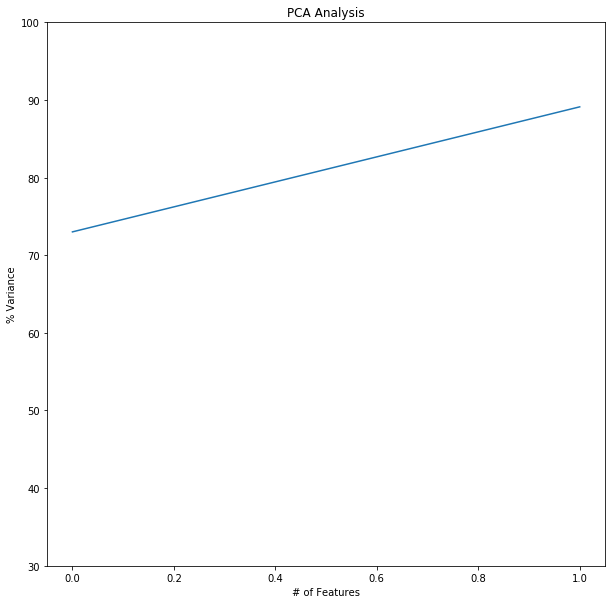

In [179]:
plt.figure(figsize=(10, 10))
plt.ylabel('% Variance')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.ylim(30, 100)
plt.plot(pca_variance)
plt.show()

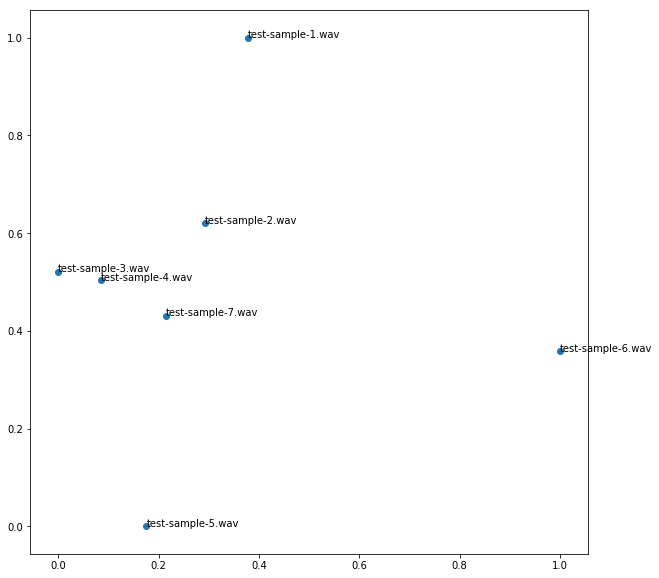

In [180]:
plt.figure(figsize=(10, 10))
plt.scatter(pca.T[0], pca.T[1])
for i, label in enumerate(file_names):
    plt.annotate(label, (pca.T[0][i], pca.T[1][i]))
plt.show()